# Objective
The objetive of this notebook is to replicate example of section 12.2 https://otexts.com/fpp3/prophet.html.

# Description of the data
The dataset is quaterly cement production data. As mentioned in the book, the series is relatively long so we will divide the data into train and test.

# Imports, configuration and constants

In [40]:
from os import path
from typing import Optional

import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
PLOT_TITLE = "AUS cement production"
PLOT_YLABEL = "Cement"
PLOT_XLABEL = "Quarter"

# Functions

In [61]:
def plot_cement_df(df: pd.DataFrame, start_time: str=None, end_time: str=None):
    
    df = df.copy()
    
    if start_time is not None:
        df = df.query('date >= @start_time')
    if end_time is not None:
        df = df.query('date <= @end_time')
        
    x = df.date
    y = df.cement
    
    plt.plot(x, y)
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    

def filter_time_series(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None
) -> pd.Series:
    if start_time is not None:
        ts = ts[ts.index >= start_time]
    if end_time is not None:
        ts = ts[ts.index <= end_time]
    return ts 


def plot_single_ts(
    ts: pd.Series, 
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None
):
    
    plt.plot(ts.index, ts)
    
    if lower_ci is not None and upper_ci is not None:
        plt.fill_between(
            ts.index, 
            lower_ci, 
            upper_ci, 
            alpha=0.2, 
            label='Confidence Interval'
        )
        # plt.legend(loc='upper left')
    

def set_plot_properties(add_legend=True):
    """
    Set properties for the plot.
    """
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    
    if add_legend:
        plt.legend(loc='upper left')
    
    
def plot_single_ts_on_axis(
    ax: plt.Axes, 
    ts: pd.Series, 
    color: str, 
    label: str,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None,
):
    """
    Plot a time series and CI on an axis with a given color and label.
    """
    
    ax.plot(ts.index, ts.values, color=color, label=label)
    
    if lower_ci is not None and upper_ci is not None:
        ax.fill_between(
            ts.index, 
            lower_ci, 
            upper_ci, 
            alpha=0.2, 
            color=color, 
            label=f'{label} Confidence Interval'
        )

        
def get_color(index: int) -> str:
    """
    Get a color based on an index.
    """
    colors = ['r', 'g', 'b', 'k'] # Add more colors as needed
    return colors[index % len(colors)]


def prepare_labels(n_ts: int, labels: Optional[list[str]]) -> list[str]:
    """
    Create labels if they are None.
    """
    
    if labels:
        return labels
    
    labels = list()
    for i in range(n_ts):
        labels.append(f'TS {i+1}')
        
    return labels
    

def plot_cement_ts(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None
):
    ts = filter_time_series(ts, start_time, end_time)
    if lower_ci is not None:
        lower_ci = filter_time_series(lower_ci, start_time, end_time)
    if upper_ci is not None:
        upper_ci = filter_time_series(upper_ci, start_time, end_time)
        
    plot_single_ts(ts, lower_ci, upper_ci)
    set_plot_properties(add_legend=False)
    plt.show()
    
    
def plot_cement_multiple_ts(
    ts_list: list[pd.Series],
    start_time: str = None,
    end_time: str = None,
    lower_ci_list: Optional[list[pd.Series]] = None,
    upper_ci_list: Optional[list[pd.Series]] = None,
    labels: Optional[list[str]] = None,
):
    """
    Plot multiple time series predictions with their respective confidence intervals on the same plot.
    """
    
    labels = prepare_labels(len(ts_list), labels)
    
    fig, ax = plt.subplots()
    
    for i in range(len(ts_list)):
        ts = ts_list[i]
        lower_ci = lower_ci_list[i]
        upper_ci = upper_ci_list[i]
        
        ts = filter_time_series(ts, start_time, end_time)
        if lower_ci is not None:
            lower_ci = filter_time_series(lower_ci, start_time, end_time)
        if upper_ci is not None:
            upper_ci = filter_time_series(upper_ci, start_time, end_time)
            
        color = get_color(i)
        label = labels[i]
        
        plot_single_ts_on_axis(ax, ts, color, label, lower_ci, upper_ci)

    set_plot_properties()
    plt.show()    
    
    
def join_forecast_to_series(
    ts: pd.Series,
    ts_index: pd.Index,
    ts_h: pd.Series,
    ts_h_lower: pd.Series,
    ts_h_upper: pd.Series
) -> tuple[pd.Series, pd.Series, pd.Series]:
    
    ts_with_h = ts.copy()
    # Recovering the series index
    ts_with_h.index = ts_index
    ts_with_h = pd.concat([ts_with_h, ts_h])

    ts_with_h_lower = ts_with_h.copy()
    ts_with_h_lower[ts.index] = None
    ts_with_h_lower[ts_h_lower.index] = ts_h_lower

    ts_with_h_upper = ts_with_h.copy()
    ts_with_h_upper[ts.index] = None
    ts_with_h_upper[ts_h_upper.index] = ts_h_upper
    
    return ts_with_h, ts_with_h_lower, ts_with_h_upper

# Load data

In [7]:
data_dir_path = "../data-raw/"
aus_production_path = path.join(data_dir_path, "aus_production.csv")

df = pd.read_csv(aus_production_path, sep='|')
df.columns = df.columns.str.lower()

# Prepare data
Filter the data as done in the book.

In [8]:
df = df.rename(columns={"quarter": "year_quarter"})

# Split the 'year_quarter' column into separate 'year' and 'quarter' columns
df[['year', 'quarter']] = df['year_quarter'].str.split(' Q', expand=True)

# Combine the 'year' and 'quarter' columns into a datetime column
df['date'] = (
    pd.PeriodIndex(
        year=df['year'].astype(int), 
        quarter=df['quarter'].astype(int)
    ).to_timestamp()
)

df = df[["cement", "date"]]
df = df[df.date >= "1988-01-01"]

df.head()

,cement,date
128,1418,1988-01-01
129,1625,1988-04-01
130,1770,1988-07-01
131,1791,1988-10-01
132,1621,1989-01-01


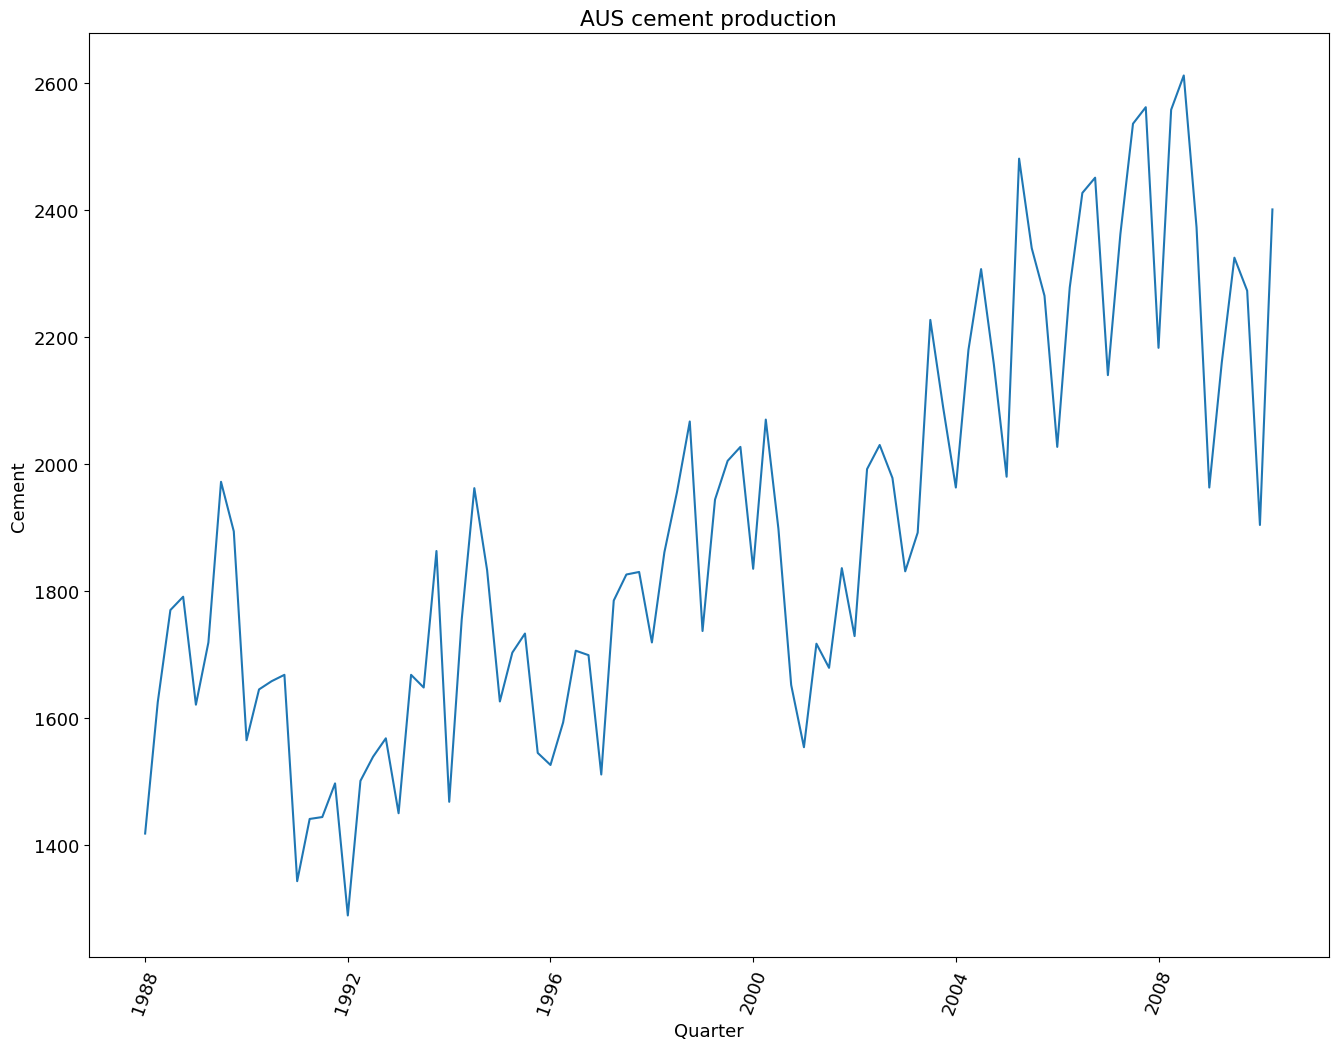

In [10]:
plot_cement_df(df, start_time=1988)

In [11]:
ts = pd.Series(df.cement.values, index=df.date)
ts.head()

date
1988-01-01    1418
1988-04-01    1625
1988-07-01    1770
1988-10-01    1791
1989-01-01    1621
dtype: int64

In [12]:
date_split = "2007-01-01"

ts_train = ts[ts.index <= date_split]
ts_test = ts[ts.index > date_split]

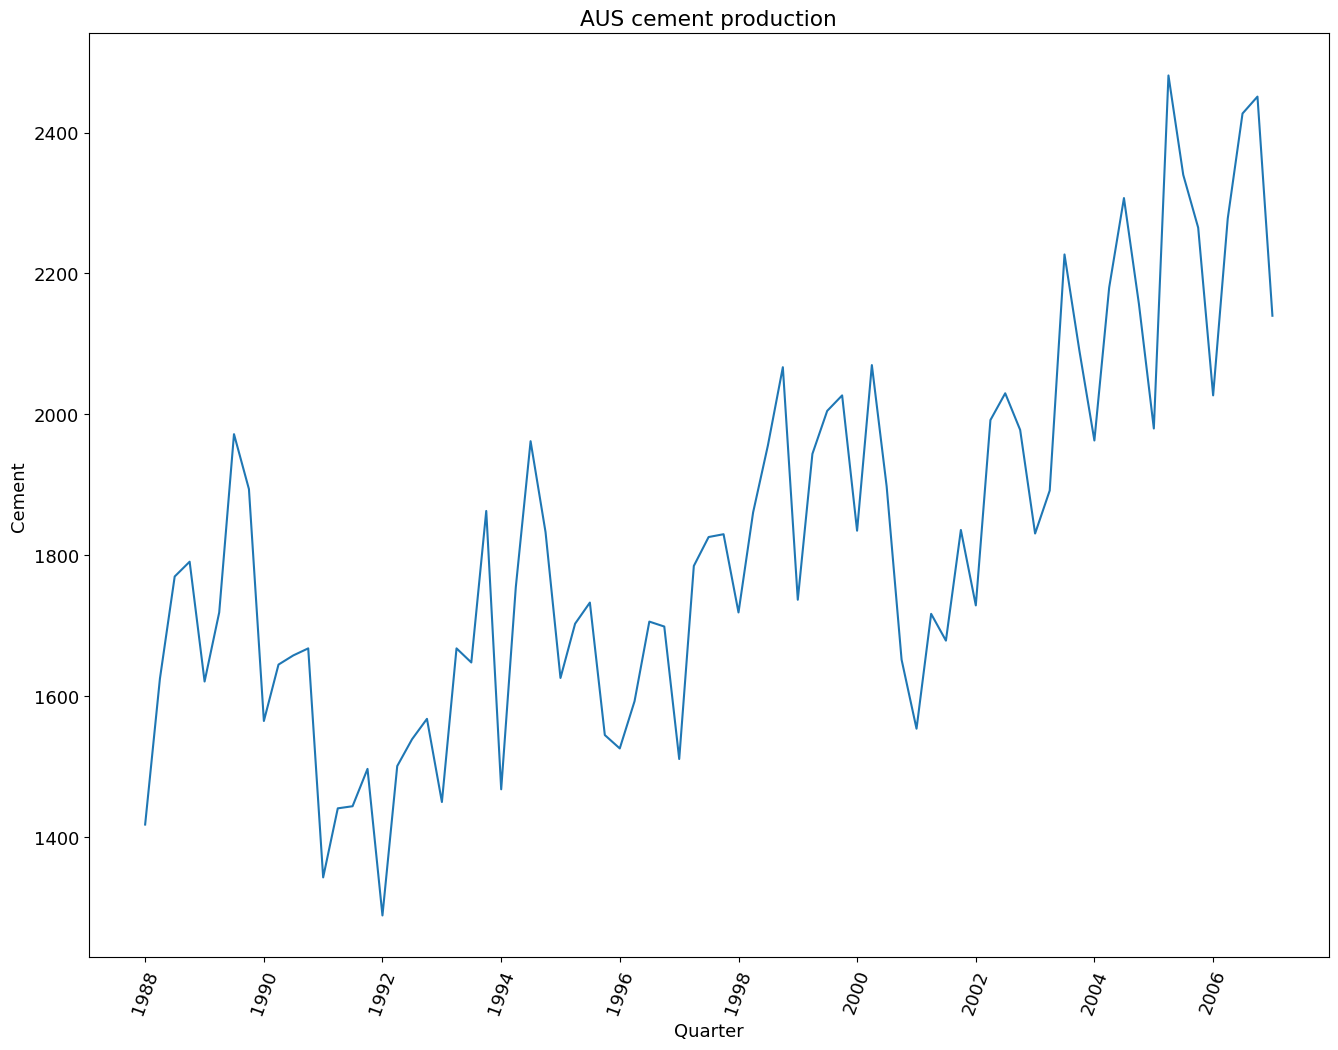

In [20]:
plot_cement_ts(ts_train)

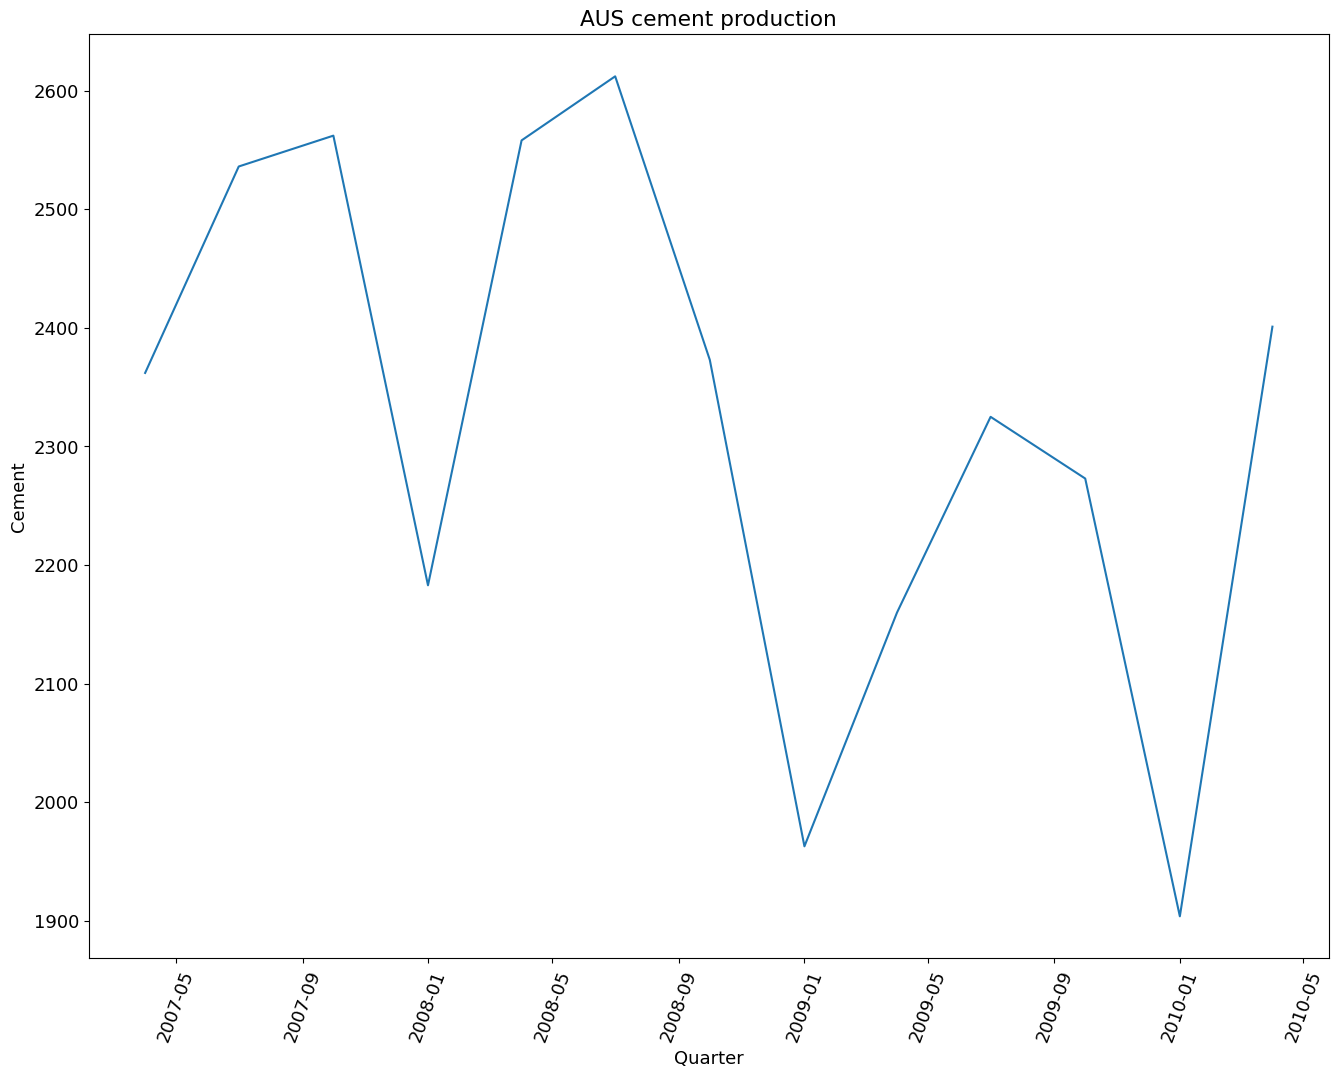

In [21]:
plot_cement_ts(ts_test)

# Forecasting
## ARIMA

From the https://otexts.com/fpp3/arima-ets.html#comparing-arima-and-ets-on-seasonal-data section we know that the model that was used is `ARIMA(1,0,1)(2,1,1)[4] w/ drift`.

The drift concept is better explained in the previous version of the book https://otexts.com/fpp2/arima-r.html. In this link we can see an explanation about the drift in statsmodels https://stackoverflow.com/questions/66651360/arima-forecast-gives-different-results-with-new-python-statsmodels.

In [31]:
arima = ARIMA(endog=ts_train, order=(1,0,1), seasonal_order=(2,1,1,4), trend="t")
res = arima.fit()

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

The summary is very similar to the one obtain in the book example even if we have not reached convergence.

In [28]:
print(res.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                   77
Model:             ARIMA(1, 0, 1)x(2, 1, 1, 4)   Log Likelihood                -444.964
Date:                         Tue, 18 Apr 2023   AIC                            903.929
Time:                                 20:02:46   BIC                            919.962
Sample:                             01-01-1988   HQIC                           910.318
                                  - 01-01-2007                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.5567      2.393      3.993      0.000       4.866      14.248
ar.L1          0.8505      0.133      6.396      0.000     

Lets explain how some of the following plots work.

**QQ plots**

QQ plots (quantile-quantile plots) are often used in linear regression to assess whether the residuals of a regression model follow a normal distribution. A residual is the difference between the observed response values and the predicted response values from a linear regression model.

In linear regression, we assume that the residuals are normally distributed with a mean of 0 and a constant variance. The normality assumption is important because if the residuals are not normally distributed, it can affect the accuracy of our regression model and the validity of our statistical inference.

A QQ plot compares the quantiles of the residuals to the quantiles of a normal distribution. If the residuals are normally distributed, the points in the QQ plot will follow a straight line. If the residuals are not normally distributed, the points in the QQ plot will deviate from a straight line.

Thus, QQ plots can be used to visually assess whether the residuals of a regression model follow a normal distribution. If the points in the QQ plot follow a straight line, we can be more confident that the normality assumption is met. If the points deviate from a straight line, we may need to transform the response variable or the predictor variables, or consider a different type of regression model.

I hope that helps! Let me know if you have any further questions.

**Correlogram**

A correlogram, also known as an autocorrelation plot, is a plot that shows the correlation of a time series with its lagged values. In ARIMA modeling, a correlogram is a commonly used diagnostic tool to assess the presence of autocorrelation in the residuals of the ARIMA model.

Autocorrelation is a measure of the correlation between a time series and a lagged version of itself. If there is autocorrelation present in the residuals of an ARIMA model, it means that there is some pattern in the residuals that can be explained by the past values of the series. This violates the assumption of independence of errors, which is necessary for statistical inference.

To create a correlogram, we plot the autocorrelation function (ACF) of the residuals against the number of lags. The ACF measures the correlation between the residuals at a certain lag and the residuals at all the previous lags. If the ACF values are significant at some lag(s), it means that there is autocorrelation present in the residuals at that lag(s).

A correlogram can help us identify whether there is autocorrelation present in the residuals and the order of the AR or MA terms that we may need to add to the ARIMA model to account for the autocorrelation. If the ACF values drop off quickly and become insignificant, it suggests that the residuals are not correlated with the lagged values and that the ARIMA model may be a good fit for the data.

In summary, a correlogram is a useful tool for ARIMA model diagnostics, and it helps us to identify whether autocorrelation is present in the residuals of the model, and if so, what type of ARIMA model we may need to use to account for it.

**Our diagnostics**

As we can appreciate from the histogram and the QQ plot the residuals follow a normal distribution. Also, we can notice that our correlogram shows no correlations in the residuals.

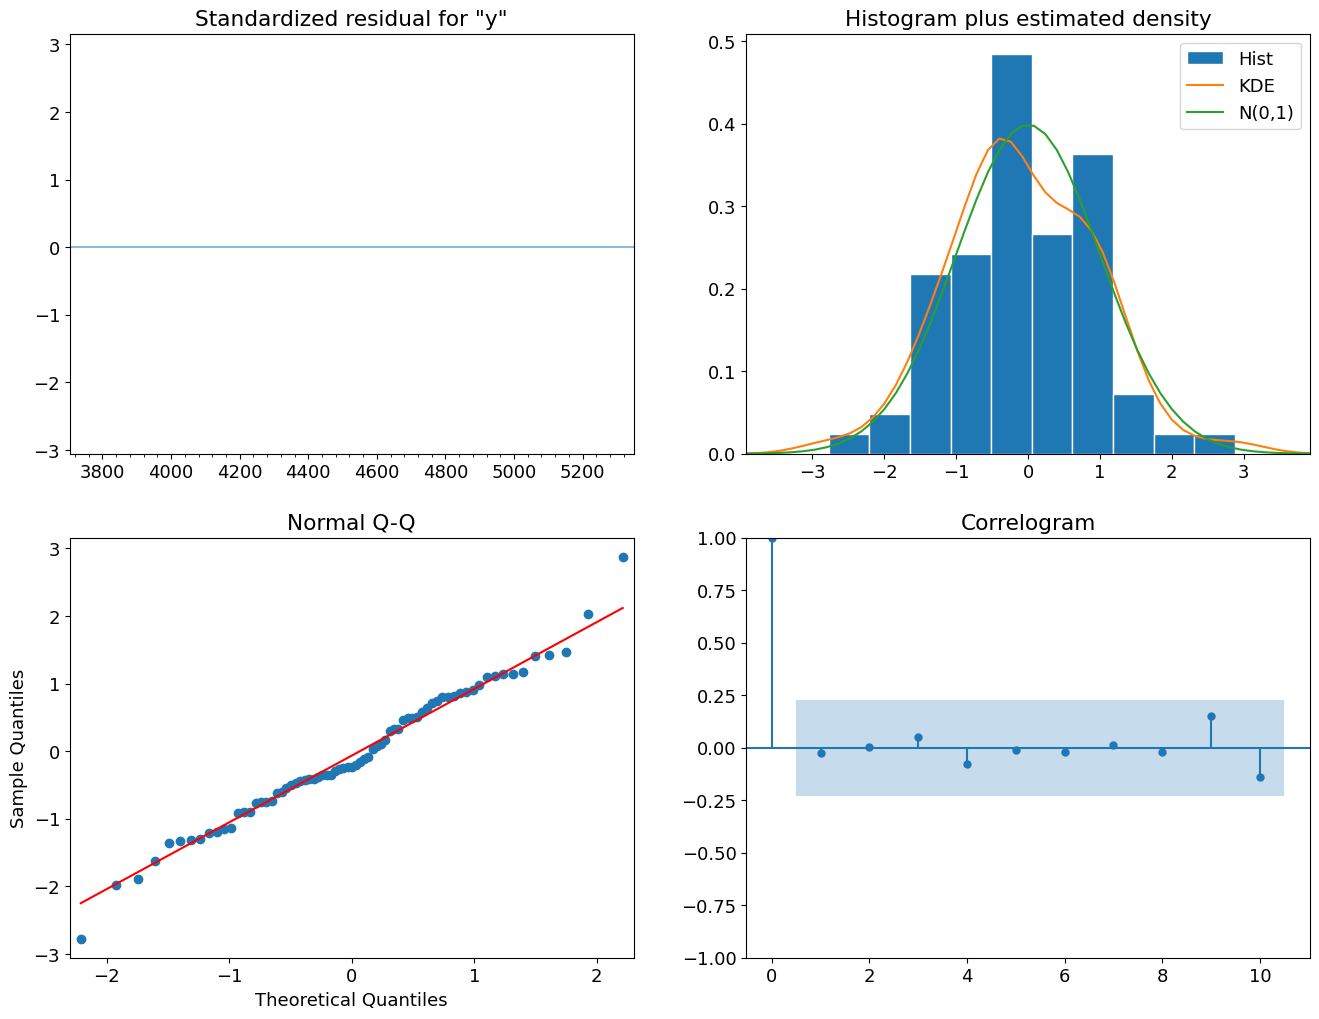

In [33]:
res.plot_diagnostics();

Lets forecast the test period.

In [34]:
pred = res.get_prediction(
    start=ts_test.index[0], 
    end=ts_test.index[-1],
)

df_pred = pred.summary_frame(alpha=0.05)

In [35]:
ts_arima_h = pd.Series(
    df_pred['mean'].values, 
    index=df_pred.index,
)

ts_arima_h_lower = pd.Series(
    df_pred['mean_ci_lower'].values, 
    index=df_pred.index,
)

ts_arima_h_upper = pd.Series(
    df_pred['mean_ci_upper'].values, 
    index=df_pred.index,
)

Visualizing the forecast.

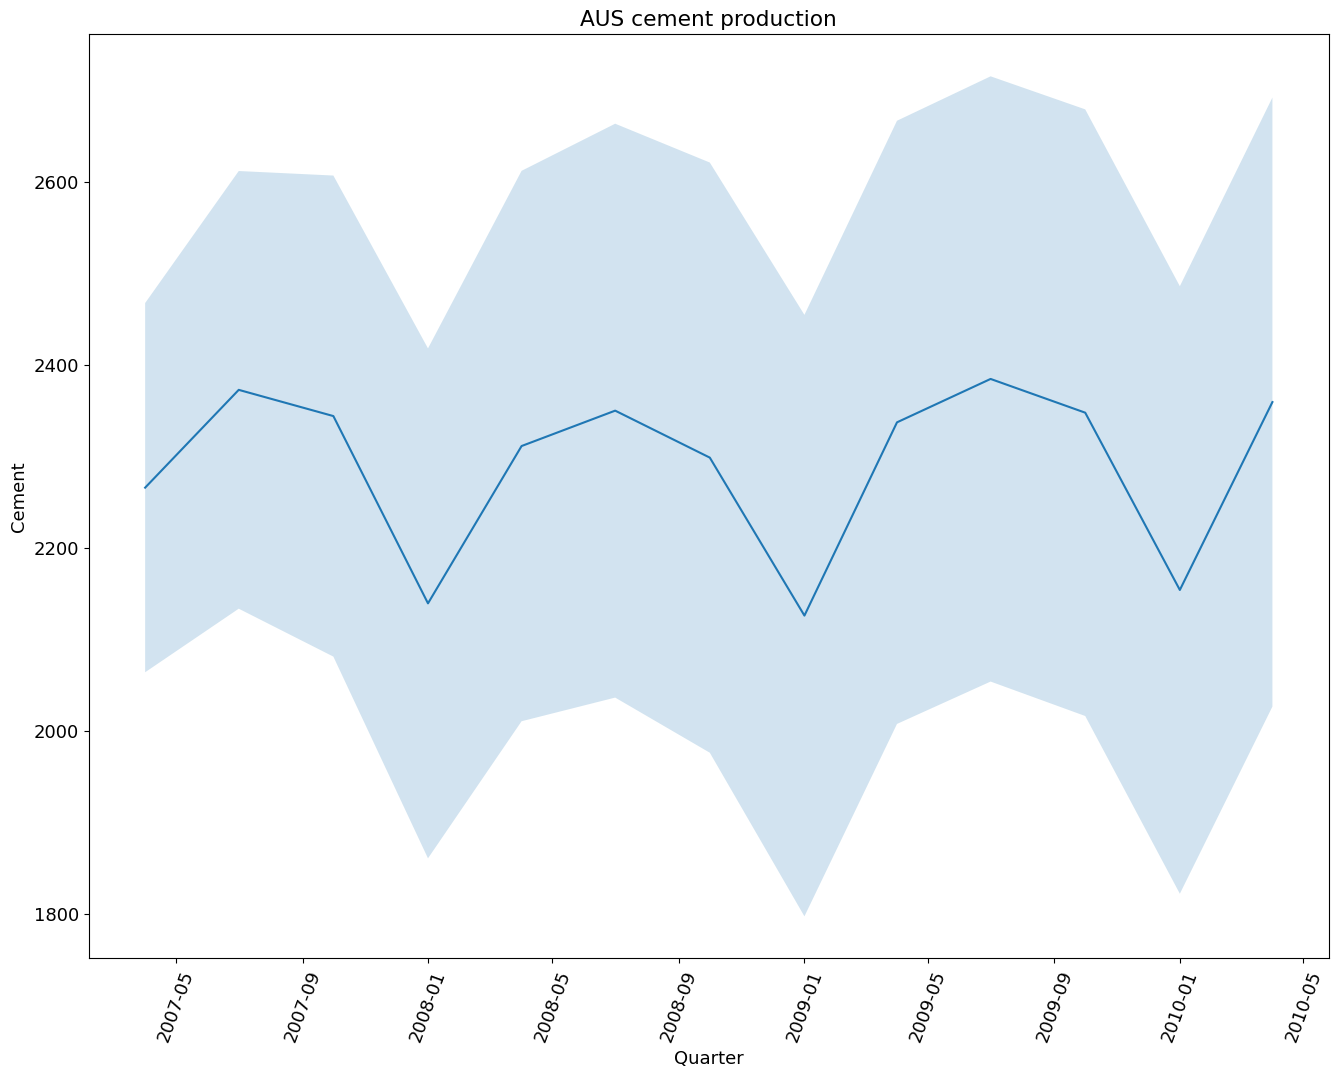

In [36]:
plot_cement_ts(ts_arima_h, lower_ci=ts_arima_h_lower, upper_ci=ts_arima_h_upper)

## ETS 
From the books example in https://otexts.com/fpp3/arima-ets.html we can see the type of ETS model finally selected is ETS(M,N,M). From the R documentation https://www.rdocumentation.org/packages/forecast/versions/8.21/topics/ets we know that:
- The first letter denotes the error type ("A", "M" or "Z");
- The second letter denotes the trend type ("N","A","M" or "Z")
- The third letter denotes the season type ("N","A","M" or "Z").
- In all cases, "N"=none, "A"=additive, "M"=multiplicative and "Z"=automatically selected

In [37]:
ets = ETSModel(ts_train, error="mul", trend=None, seasonal="mul")
fit = ets.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89506D+00    |proj g|=  2.16779D+00

At iterate    1    f=  6.80950D+00    |proj g|=  1.52407D+00

At iterate    2    f=  6.45274D+00    |proj g|=  4.45257D-01

At iterate    3    f=  6.35943D+00    |proj g|=  5.11192D-01

At iterate    4    f=  6.27466D+00    |proj g|=  5.18173D-01

At iterate    5    f=  6.24028D+00    |proj g|=  4.57977D-01

At iterate    6    f=  6.19143D+00    |proj g|=  4.07625D-01

At iterate    7    f=  6.16006D+00    |proj g|=  1.38916D-01

At iterate    8    f=  6.15481D+00    |proj g|=  2.28032D-01

At iterate    9    f=  6.15166D+00    |proj g|=  6.88235D-02

At iterate   10    f=  6.15083D+00    |proj g|=  6.14847D-02

At iterate   11    f=  6.15025D+00    |proj g|=  7.25759D-02

At iterate   12    f=  6.14928D+00    |proj g|=  5.69084D-02

At iterate   13    f=  6.1

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


The fitted values look similar to the train series.

<Axes: xlabel='date'>

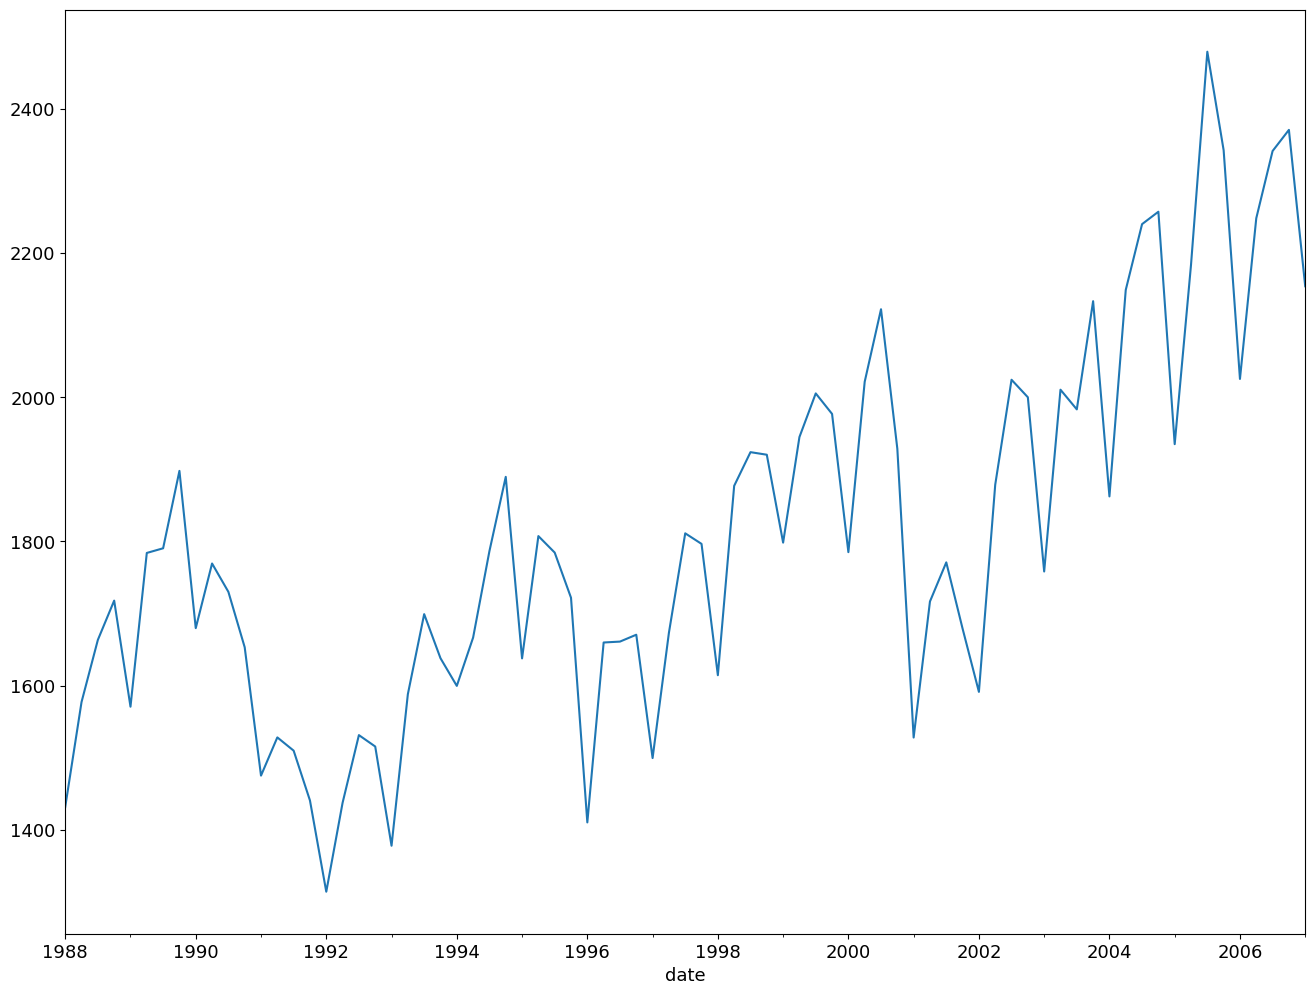

In [39]:
fit.fittedvalues.plot(label="statsmodels fit")

Our results are reasonably similar to the ones of the book (they are actually better according to the metrics).

In [48]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   77
Model:                       ETS(MNM)   Log Likelihood                -464.406
Date:                Tue, 18 Apr 2023   AIC                            944.811
Time:                        20:27:34   BIC                            963.562
Sample:                    01-01-1988   HQIC                           952.311
                         - 01-01-2007   Scale                            0.003
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.7406      0.092      8.072      0.000       0.561       0.920
smoothing_seasonal  2.594e-05        nan        nan        nan         nan         nan
initial_level       

Lets forecast the test period.

In [49]:
pred = fit.get_prediction(
    start=ts_test.index[0], 
    end=ts_test.index[-1]
)

df_pred = pred.summary_frame(alpha=0.05)

In [50]:
df_pred.head()

,mean,mean_numerical,pi_lower,pi_upper
2007-04-01,2378.297057,2377.860262,2113.221305,2645.184673
2007-07-01,2453.066155,2451.008845,2116.621482,2784.492680
2007-10-01,2418.550131,2413.773606,2059.900966,2809.736529
2008-01-01,2143.635272,2140.926162,1757.307553,2531.596235
2008-04-01,2378.297057,2378.150462,1935.071015,2829.321207


In [51]:
ts_ets_h = pd.Series(
    df_pred['mean'].values, 
    index=df_pred.index,
)

ts_ets_h_lower = pd.Series(
    df_pred['pi_lower'].values, 
    index=df_pred.index,
)

ts_ets_h_upper = pd.Series(
    df_pred['pi_upper'].values, 
    index=df_pred.index,
)

Visualizing the plots.

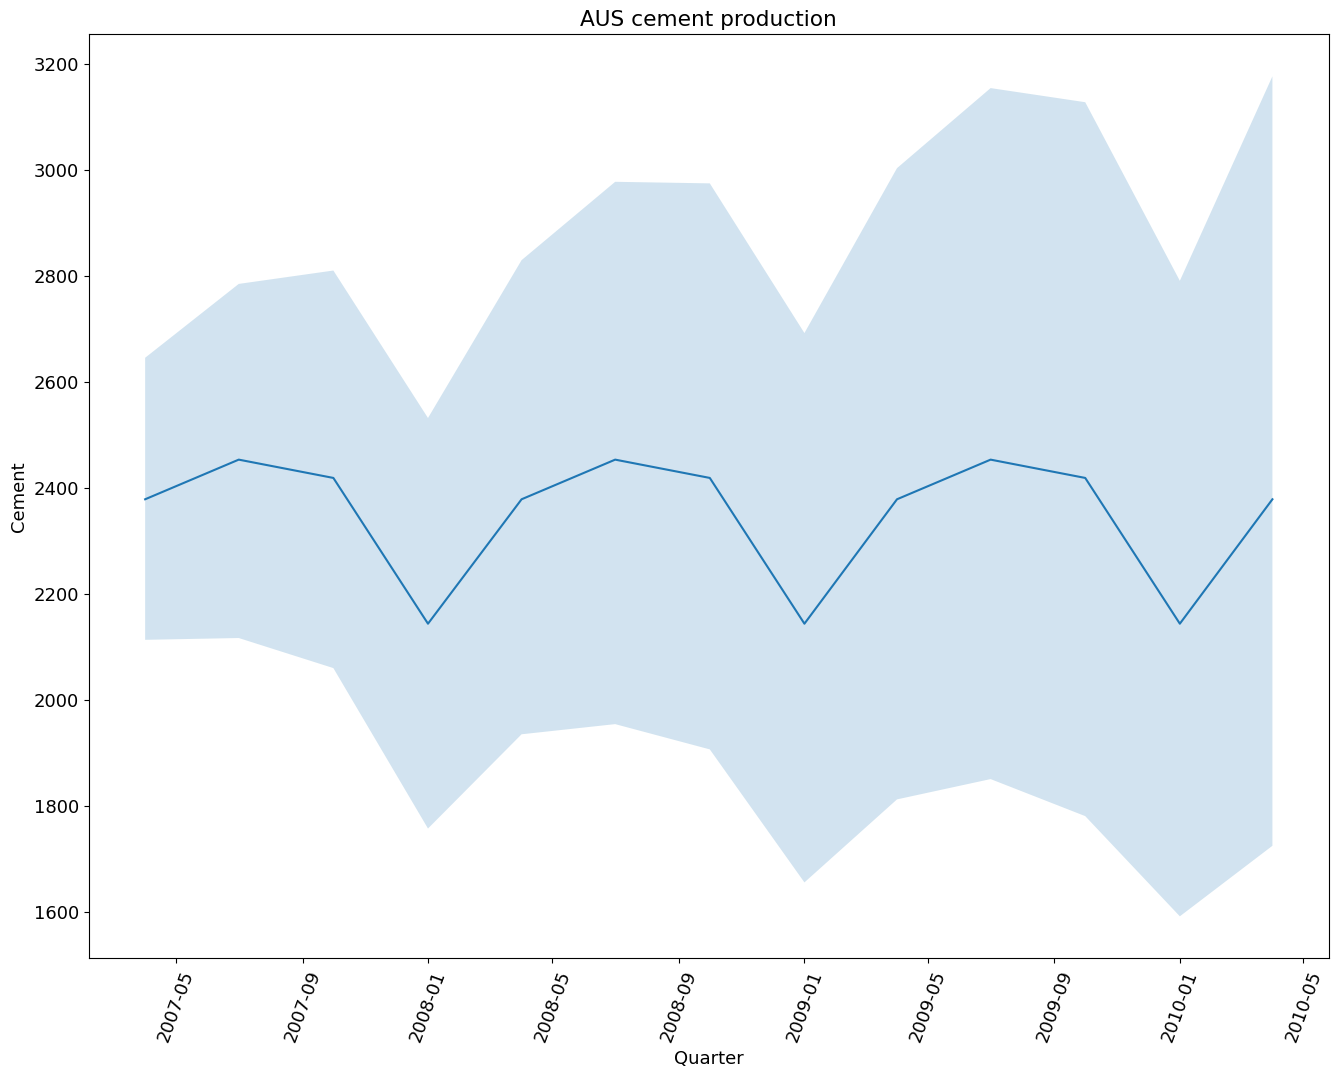

In [52]:
plot_cement_ts(ts_ets_h, lower_ci=ts_ets_h_lower, upper_ci=ts_ets_h_upper)

## Prophet
Again, we copy the model from the book https://otexts.com/fpp3/prophet.html.

Firstly, we transform the data so that it can be ingested by Prophet.

In [53]:
df_train = (
    pd.DataFrame({
        'ds': ts_train.index.tolist(),
        'y': ts_train
    })
    .reset_index(drop=True)
)

In [54]:
m = Prophet()
m.add_seasonality(name='q', period=4, fourier_order=2, mode='multiplicative')
m.fit(df_train)

20:27:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:46 - cmdstanpy - INFO - Chain [1] done processing


We forecast the test series.

In [55]:
# This function is not working as expected
# future = m.make_future_dataframe(periods=13, freq='Q')

future = (
    pd.DataFrame({
        'ds': ts_test.index.tolist(),
    })
    .reset_index(drop=True)
)
future

,ds
0,2007-04-01
1,2007-07-01
2,2007-10-01
3,2008-01-01
4,2008-04-01
5,2008-07-01
6,2008-10-01
7,2009-01-01
8,2009-04-01
9,2009-07-01


In [56]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8,2009-04-01,2212.316518,2053.996948,2366.139261
9,2009-07-01,2610.639606,2454.959297,2772.611714
10,2009-10-01,2616.839057,2448.389909,2777.275498
11,2010-01-01,2403.118948,2251.128774,2560.018363
12,2010-04-01,2372.146731,2217.876059,2531.614343


In [57]:
ts_pro_h = pd.Series(
    forecast['yhat'].values, 
    index=forecast['ds'],
)

ts_pro_h_lower = pd.Series(
    forecast['yhat_lower'].values, 
    index=forecast['ds'],
)

ts_pro_h_upper = pd.Series(
    forecast['yhat_upper'].values, 
    index=forecast['ds'],
)

Visualizing the results.

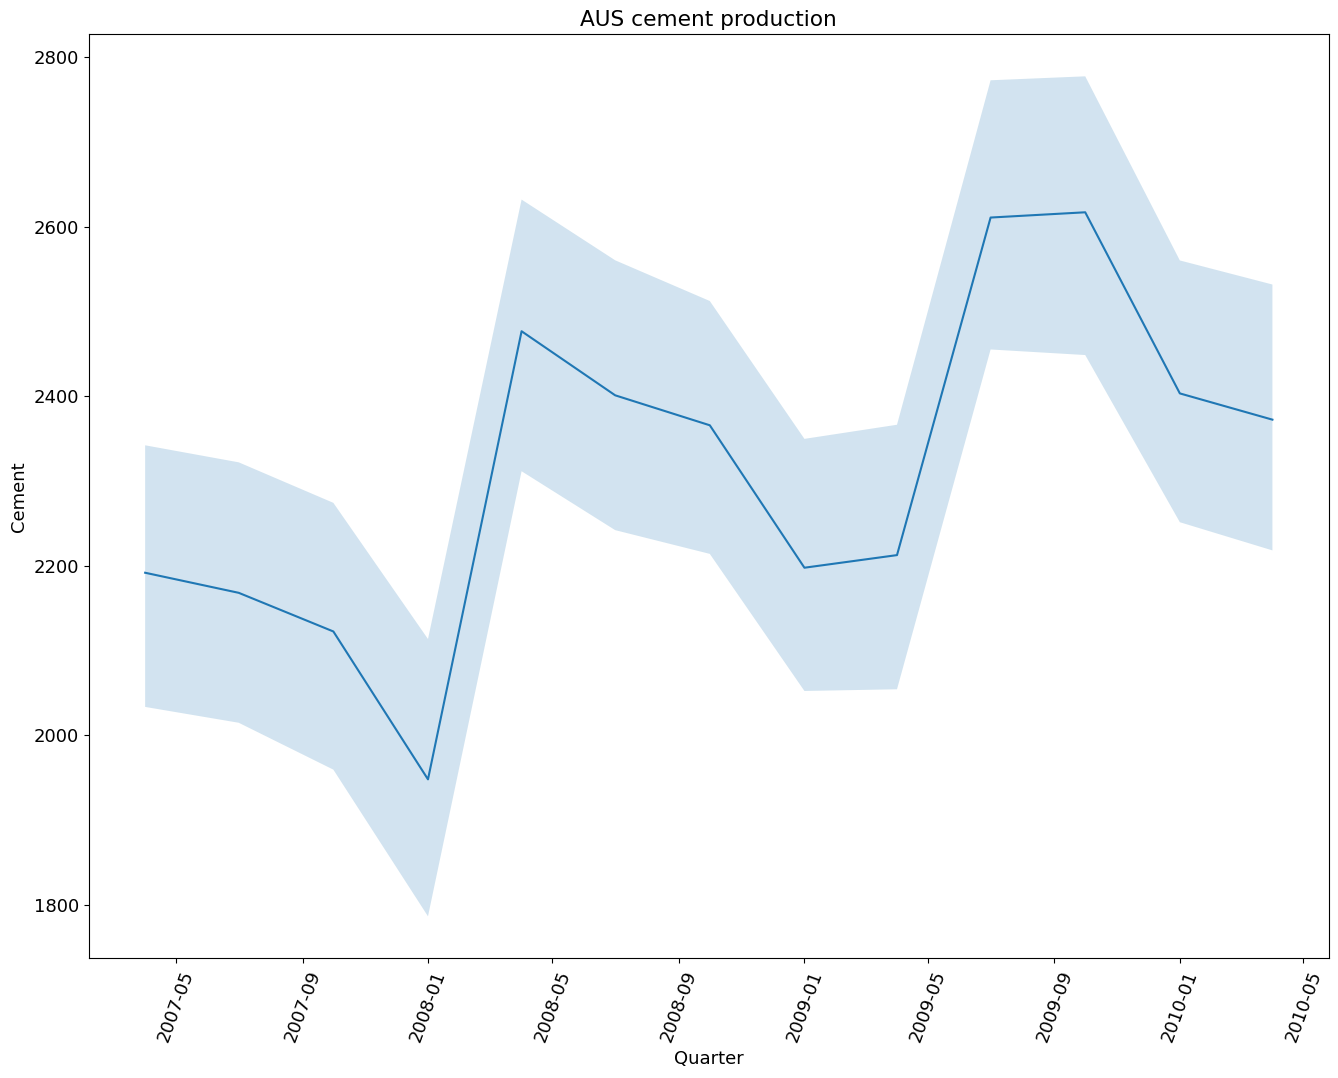

In [58]:
plot_cement_ts(ts_pro_h, lower_ci=ts_pro_h_lower, upper_ci=ts_pro_h_upper)

## All
Lets see all the different forecast together.

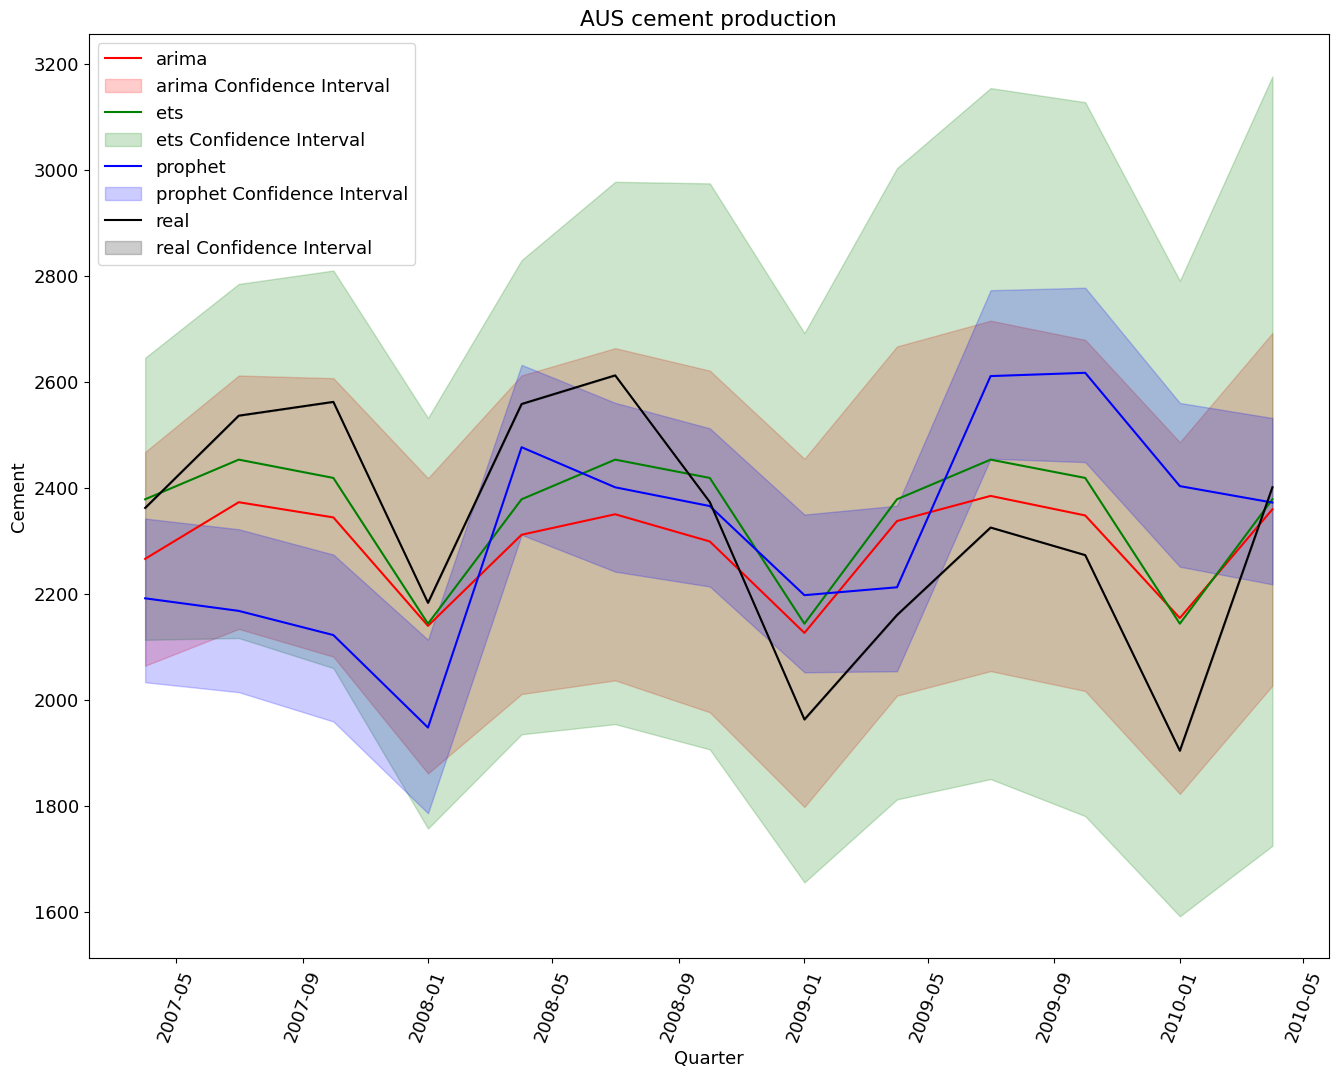

In [60]:
labels = ["arima", "ets", "prophet", "real",]

ts_hs = [
    ts_arima_h,
    ts_ets_h,
    ts_pro_h,
    ts_test,
]

ts_hs_lower = [
    ts_arima_h_lower,
    ts_ets_h_lower,
    ts_pro_h_lower,
    ts_test,
]

ts_hs_upper = [
    ts_arima_h_upper,
    ts_ets_h_upper,
    ts_pro_h_upper,
    ts_test,
]


plot_cement_multiple_ts(
    ts_hs,
    lower_ci_list=ts_hs_lower,
    upper_ci_list=ts_hs_upper,
    labels=labels,
)


In [62]:
ts_with_hs = list()
ts_with_hs_lower = list()
ts_with_hs_upper = list()

for i in range(len(ts_hs)):
    ts_with_h, ts_with_h_lower, ts_with_h_upper = join_forecast_to_series(
        ts_train,
        ts_train.index,
        ts_hs[i],
        ts_hs_lower[i],
        ts_hs_upper[i],
    )
    ts_with_hs.append(ts_with_h)
    ts_with_hs_lower.append(ts_with_h_lower)
    ts_with_hs_upper.append(ts_with_h_upper)

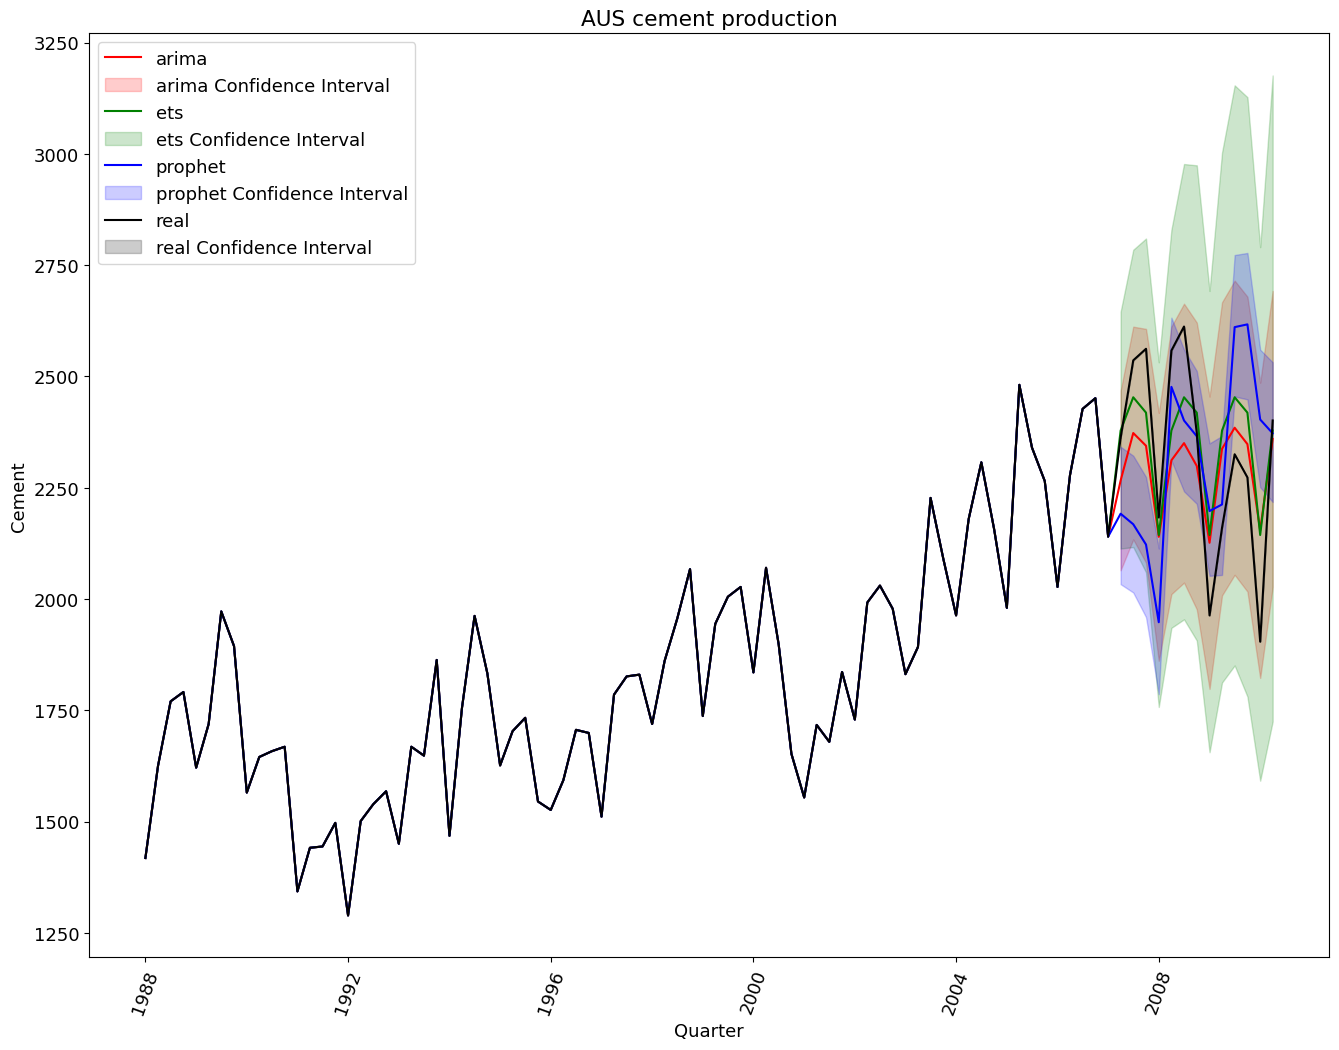

In [63]:
plot_cement_multiple_ts(
    ts_with_hs,
    lower_ci_list=ts_with_hs_lower,
    upper_ci_list=ts_with_hs_upper,
    labels=labels,
)

As we can see our metrics for ARIMA and ETS are better than the ones in the book for the same models. This is probably due to some differences in the implementations and solvers. With respect to Prophet our results are worse. This is interesting as the same library is used both for Python and R.

In [71]:
metrics_list = list()
for i in range(len(ts_hs)):
    metrics = dict(
        model=labels[i],
        rmse=mean_squared_error(ts_test, ts_hs[i], squared=False),
        mae=mean_absolute_error(ts_test, ts_hs[i]),
        mape=mean_absolute_percentage_error(ts_test, ts_hs[i]),
    )
    
    metrics_list.append(metrics)
    
df_metrics = pd.DataFrame(metrics_list)

df_metrics

,model,rmse,mae,mape
0,arima,164.498159,143.865311,0.062348
1,ets,142.696010,123.163019,0.054726
2,prophet,273.462144,227.547945,0.100354
3,real,0.000000,0.000000,0.000000
